In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA




In [4]:
customers_path = "Customers.csv"
products_path = "Products.csv"
transactions_path = "Transactions.csv"

customers = pd.read_csv(customers_path)
products = pd.read_csv(products_path)
transactions = pd.read_csv(transactions_path)





In [5]:
data = transactions.merge(customers, on='CustomerID', how='left')
data = data.merge(products, on='ProductID', how='left')



data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
customer_summary = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count',
    'Price_x': 'mean'
}).rename(columns={
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount',
    'Price_x': 'AveragePrice'
})




In [6]:
customer_features = customers.merge(customer_summary, on='CustomerID', how='left')
customer_features.fillna(0, inplace=True)


scaler = StandardScaler()
numeric_features = ['TotalSpent', 'TotalQuantity', 'TransactionCount', 'AveragePrice']
customer_features_scaled = scaler.fit_transform(customer_features[numeric_features])


optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)




Davies-Bouldin Index: 0.991545271778743


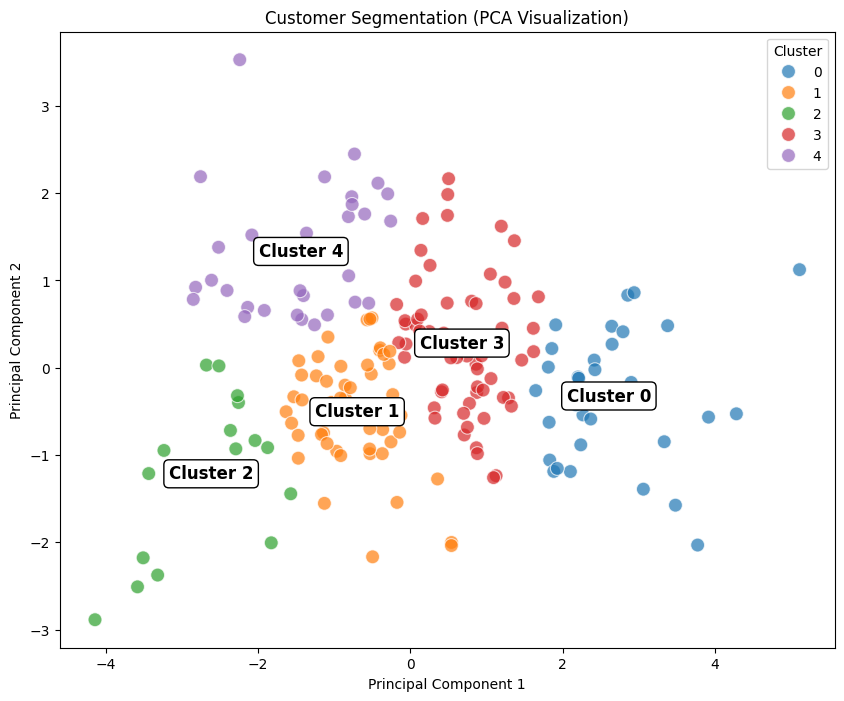

In [7]:
db_index = davies_bouldin_score(customer_features_scaled, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


pca = PCA(n_components=2)
pca_result = pca.fit_transform(customer_features_scaled)
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features,
    palette='tab10', s=100, alpha=0.7
)
plt.title("Customer Segmentation (PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')



for cluster in customer_features['Cluster'].unique():
    cluster_center = customer_features[customer_features['Cluster'] == cluster][['PCA1', 'PCA2']].mean()
    plt.text(
        cluster_center['PCA1'], cluster_center['PCA2'], f"Cluster {cluster}",
        fontsize=12, weight='bold', color='black', ha='center', va='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.show()


In [8]:
clustering_path = "Clustering_Results.csv"
customer_features[['CustomerID', 'Cluster']].to_csv(clustering_path, index=False)
print(f"Clustering results saved to {clustering_path}")


Clustering results saved to Clustering_Results.csv
